# Convolutional Auto Encoder- Decoder and 2D CNN on CIFAR-10 – Image Classification

# Introduction

Here I have designed a network that combines supervised and unsupervised architectures in one model to achieve a classification on CIFAR-10 datasets. So, for this I build a encoder model and this model compressed the image data and after decoder model decompressed the data and again this model reconstruct the original image. 

Another part of this notebook is to used the Pre-Training CNNs Using Convolutional Autoencoders to classify the image.


### Python dependency package requirement list

scikit-image     == 0.16.2   

scikit-learn     == 0.23.1    

scipy          ==1.5.2 

seaborn      == 0.11.0 

tensorboard   ==2.2.2  

tensorflow    == 2.2.0  

tensorflow-estimator  == 2.2.0

Keras      == 2.1.3  

ipykernel    == 5.1.4 

ipython    == 7.12.0 

matplotlib    == 3.1.3 

numpy   == 1.19.1 

Import some necessary library.

In [202]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras import datasets,Model
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,UpSampling2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization

from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report,confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import itertools
import os

# Load the dataset

CIFAR is an acronym that stands for the Canadian Institute For Advanced Research and the CIFAR-10 dataset was developed along with the CIFAR-100 dataset by researchers at the CIFAR institute.

The CIFAR10 dataset contains 60,000, 32×32 pixel color images in 10 classes, with 6,000 images in each class. The dataset is divided into 50,000 training images and 10,000 testing images. The classes are mutually exclusive and there is no overlap between them.

The class labels and their standard associated integer values are listed below.

0: airplane
1: automobile
2: bird
3: cat
4: deer
5: dog
6: frog
7: horse
8: ship
9: truck

In [62]:

(X_train, Y_train), (X_test,Y_test) = datasets.cifar10.load_data()

In [107]:
classes = ["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]
num_classes = 10

In [64]:
print('train image shape:',X_train.shape,'test image shape:',X_test.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

train image shape: (50000, 32, 32, 3) test image shape: (10000, 32, 32, 3)
50000 train samples
10000 test samples


Here we see there are 50000 training images and 1000 test images

In [65]:
print('Training class shape:',Y_train.shape,'Testing class shape:',Y_test.shape)

Training class shape: (50000, 1) Testing class shape: (10000, 1)


To verify that the dataset looks correct, let’s plot the some images from the test and train set and display the images.

Let's plot some images to see what they are

In [165]:
def plot_sample(X, y, index):
    plt.figure(figsize = (15,2))
    plt.imshow(X[index])
    plt.xlabel(classes[y[index]])

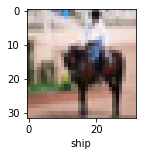

In [174]:
plot_sample(x_train, y_train, 8)


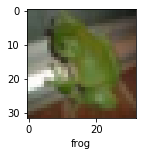

In [176]:
plot_sample(X_test, y_test, 7)

It is clear that the images are indeed very small compared to modern photographs; it can be challenging to see what exactly is represented in some of the images given the extremely low resolution.This low resolution is likely the cause of the limited performance that top-of-the-line algorithms are able to achieve on the dataset.

In [69]:
X_train.max()

255

The max pixel value is 255 for each channel. Normalize the images to a number from 0 to 1. Image has 3 channels (R,G,B) and each value in the channel can range from 0 to 255. Hence to normalize in 0-->1 range, we need to divide it by 255

Normalizing the training data

In [70]:
X_train = X_train.astype('float32') / 255.
X_test = X_test.astype('float32') / 255.

In [173]:
y_train = Y_train.reshape(-1,)
y_test = Y_test.reshape(-1,)
np.unique(Y_train)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

Y_train,y_test is a 2D array, for our classification having 1D array is good enough. so I will convert this to now 1D array
We also know that there are 10 classes and that classes are represented as unique integers.



In [206]:
y_train

array([6, 9, 9, ..., 9, 1, 1], dtype=uint8)

### Taking 50% of ["bird","deer","truck"] class in the training data.

In [207]:
def Data_Decrease(X_train,Y_train,percent,class_name):
    del_indx = []
    import random
    for name in class_name:
        cls_indx = classes.index(name)
        indx = np.where(Y_train==cls_indx)[0]
        upto = int(len(indx)*percent/100)
        ind = indx[random.sample(range(0,len(indx)),upto)]
        print('Shape of',name,'class:',indx.shape,'after taking',percent,'% shape:',ind.shape)
        del_indx.append(list(ind))

    del_indx = list(itertools.chain.from_iterable(del_indx))
    ls =list(range(0,len(X_train)))
    # desired_indx = [i for i in ls if i not in indx_total]
    desired_indx = list(set(ls) - set(del_indx))
    y_train = Y_train[desired_indx]
    x_train = X_train[desired_indx]
    print('Actual Array Shape of training data:',X_train.shape,Y_train.shape)
    print('After taking',percent,'% of ["bird","deer","truck"] classes Shape of training data:',x_train.shape,y_train.shape)
    return x_train,y_train

In [208]:
class_name = ["bird","deer","truck"]
percent = 50
x_train,y_train = Data_Decrease(X_train,Y_train,percent,class_name)

Shape of bird class: (5000,) after taking 50 % shape: (2500,)
Shape of deer class: (5000,) after taking 50 % shape: (2500,)
Shape of truck class: (5000,) after taking 50 % shape: (2500,)
Actual Array Shape of training data: (50000, 32, 32, 3) (50000, 1)
After taking 50 % of ["bird","deer","truck"] classes Shape of training data: (42500, 32, 32, 3) (42500, 1)


#  Now let us build a convolutional autoencoder to train our images

#### Important Terms of CNN and convolutional autoencoder

A convolutional neural network (CNN) applies a filter to an image in a very tricky way. When you use a CNN you have to be aware of the relationship between the image size, the filter size, the size of the padding around the image, and the distance the filter moves (the stride) during convolution.


Convolution Layer :

Convolution is the first layer to extract features from an input image. Convolution preserves the relationship between pixels by learning image features using small squares of input data. It is a mathematical operation that takes two inputs such as image matrix and a filter or kernel.Then the convolution of image matrix multiplies with filter matrix which is called Feature Map.

ReLU:

The Rectified Linear Unit (ReLU) computes the function ƒ(κ)=max (0,κ). In other words, the activation is simply threshold at zero. In comparison to sigmoid and tanh, ReLU is more reliable and accelerates the convergence by six times.

### Filter | Kernel Size | Number of Filters

Convolution is using a kernel to extract certain features from an input image.A kernel is a matrix, which is slideacross the image and multiplied with the input such that the output is enhanced in a certain desirable manner.

Before we dive into it, a kernel is a matrix of weights which are multiplied with the input to extract relevant features. The dimensions of the kernel matrix is how the convolution gets it’s name. For example, in 2D convolutions, the kernel matrix is a 2D matrix.

A filter however is a concatenation of multiple kernels, each kernel assigned to a particular channel of the input. Filters are always one dimension more than the kernels. For example, in 2D convolutions, filters are 3D matrices. So for a CNN layer with kernel dimensions hw and input channels k, the filter dimensions are kh*w.

A common convolution layer actually consist of multiple such filters.

Stride Size

Stride is the number of pixels shifts over the input matrix. When the stride is 1 then we move the filters to 1 pixel at a time. When the stride is 2 then we move the filters to 2 pixels at a time and so on. The below figure shows convolution would work with a stride of 1.

Padding

padding means giving additional pixels at the boundary of the data.Sometimes filter does not perfectly fit the input image then we will be using padding.

We have two options:

Pad the picture with zeros (zero-padding) so that it fits
Drop the part of the image where the filter did not fit. This is called valid padding which keeps only valid part of the image.
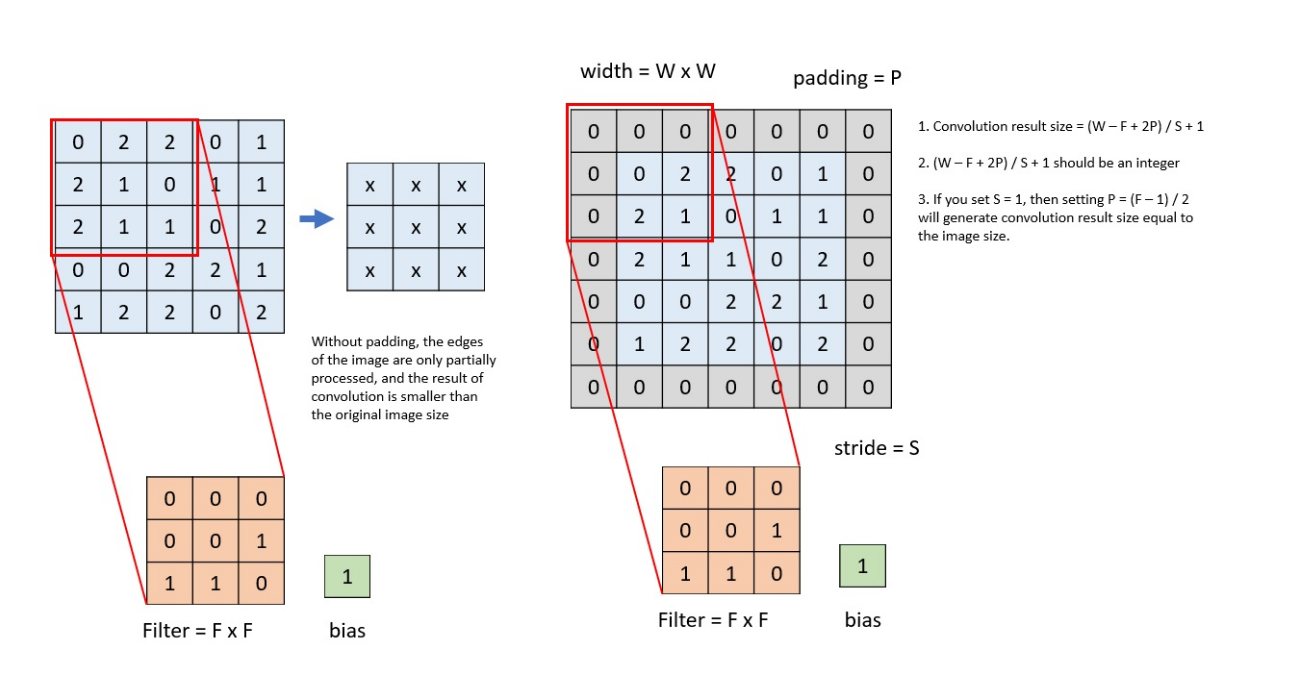


Pooling Layer

A pooling layer is a new layer added after the convolutional layer. Specifically, after a nonlinearity (e.g. ReLU) has been applied to the feature maps output by a convolutional layer;

Pooling layers section would reduce the number of parameters when the images are too large. Spatial pooling also called subsampling or downsampling which reduces the dimensionality of each map but retains important information.

Spatial pooling can be of different types:

Max Pooling
Average Pooling
Sum Pooling
Max pooling takes the largest element from the rectified feature map. Calculate the average value for each patch on the feature map is called as average pooling. Sum of all elements for each patch in the feature map call as sum pooling.

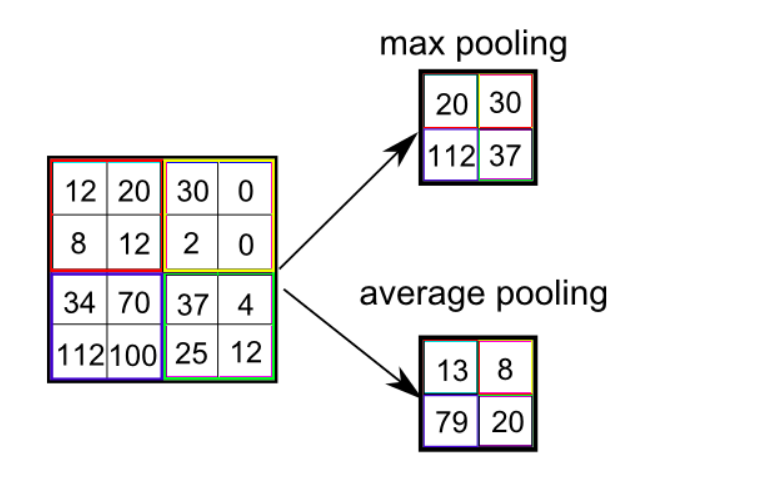

Flattening and Dense Layer

Flattening is converting the data into a 1-dimensional array for inputting it to the next layer. We flatten the output of the convolutional layers to create a single long feature vector. And it is connected to the final classification model, which is called a fully-connected layer.

Fully connected layer : A traditional multilayer perceptron structure. Its input is a one-dimensional vector representing the output of the previous layers. Its output is a list of probabilities for different possible labels attached to the image (e.g. dog, cat, bird). The label that receives the highest probability is the classification decision.



In this task we used autoencoder  and then from the output of encoder we used this layer for the classification of image. Then From this encoder output we did upsampling to reconstruction the image.

So, the experimental setup is looks like this:
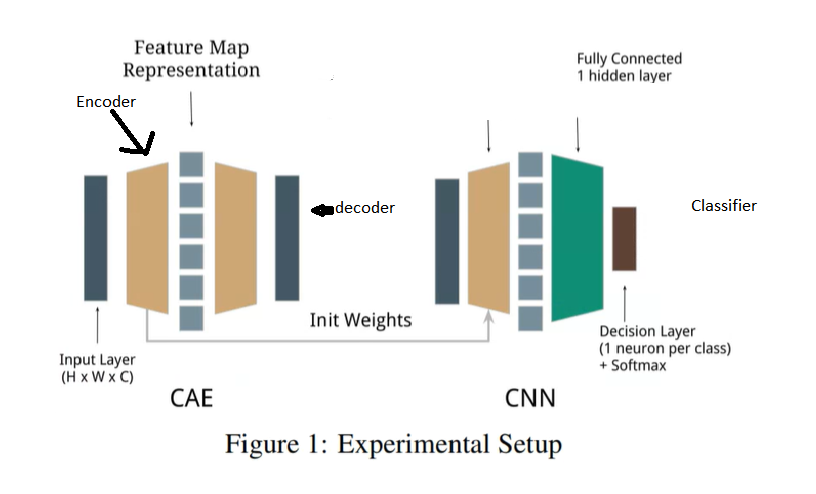

Convolutional autoencoder

Since our inputs are images, it makes sense to use convolutional neural networks (convnets) as encoders and decoders. In practical settings, autoencoders applied to images are always convolutional autoencoders --they simply perform much better.

Let's implement one. The encoder will consist in a stack of Conv2D and MaxPooling2D layers (max pooling being used for spatial down-sampling), while the decoder will consist in a stack of Conv2D and UpSampling2D layers.



Dropout() is used to by randomly set the outgoing edges of hidden units to 0 at each update of the training phase. The value passed in dropout specifies the probability at which outputs of the layer are dropped out.

The activation function used is softmax. Softmax converts a real vector to a vector of categorical probabilities. The elements of the output vector are in range (0, 1) and sum to 1. Softmax is often used as the activation for the last layer of a classification network because the result could be interpreted as a probability distribution.

#### Compile and train the model

Here we are compiling the model and fitting it to the training data. We will use 10 epochs to train the model. An epoch is an iteration over the entire data provided. validation_data is the data on which to evaluate the loss and any model metrics at the end of each epoch. The model will not be trained on this data. As metrics = ['sparse_categorical_accuracy'] the model will be evaluated based on the accuracy.

To fit the each model I checked early stopping and adjust the learning rate automatically.

In [235]:

encoder_input = keras.Input(shape=x_train.shape[1:],name="original_img")
cn = Conv2D(32, (3, 3),activation='relu',kernel_initializer='he_uniform',padding='same')(encoder_input)
cn =BatchNormalization()(cn)
cn =Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(cn)
cn =BatchNormalization()(cn)
cn =MaxPooling2D((2, 2))(cn)
cn =Dropout(0.2)(cn)
cn = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(cn)
cn =BatchNormalization()(cn)
cn =Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(cn)
cn = BatchNormalization()(cn)
encoder_output =MaxPooling2D((2, 2))(cn)
encoder = keras.Model(encoder_input, encoder_output, name="encoder")
encoder.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
original_img (InputLayer)    [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_207 (Conv2D)          (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_217 (Bat (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_208 (Conv2D)          (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_218 (Bat (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_66 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_99 (Dropout)         (None, 16, 16, 32)        0   

Plot the encoder model:

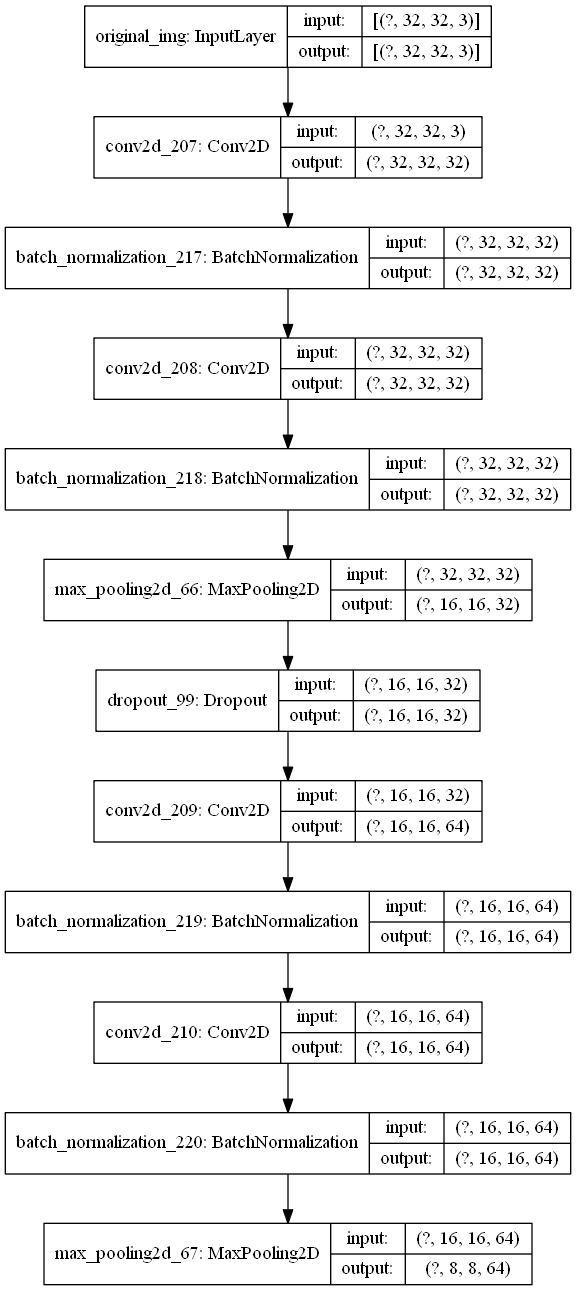

In [237]:
keras.utils.plot_model(encoder, "encoder.png", show_shapes=True)

In [210]:
cnn =Dropout(0.3)(encoder_output)
cn = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(cnn)
cnn =BatchNormalization()(cnn)
cnn =Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(cnn)
cnn = BatchNormalization()(cnn)
cnn =MaxPooling2D((2, 2))(cnn)
cnn =Dropout(0.4)(cnn)
cnn = Flatten()(cnn)
cnn =Dense(128, activation='relu', kernel_initializer='he_uniform')(cnn)
cnn =BatchNormalization()(cnn)
cnn =Dropout(0.5)(cnn)
out_layer =Dense(num_classes, activation='softmax')(cnn)
model = keras.Model(encoder_input, out_layer, name="model")
model.summary()
# compile model
opt = SGD()
model.compile(optimizer=opt, loss = 'sparse_categorical_crossentropy', metrics =['sparse_categorical_accuracy'])

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
original_img (InputLayer)    [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_201 (Conv2D)          (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_210 (Bat (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_202 (Conv2D)          (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_211 (Bat (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_63 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_95 (Dropout)         (None, 16, 16, 32)        0     

Plot the Classifier model:

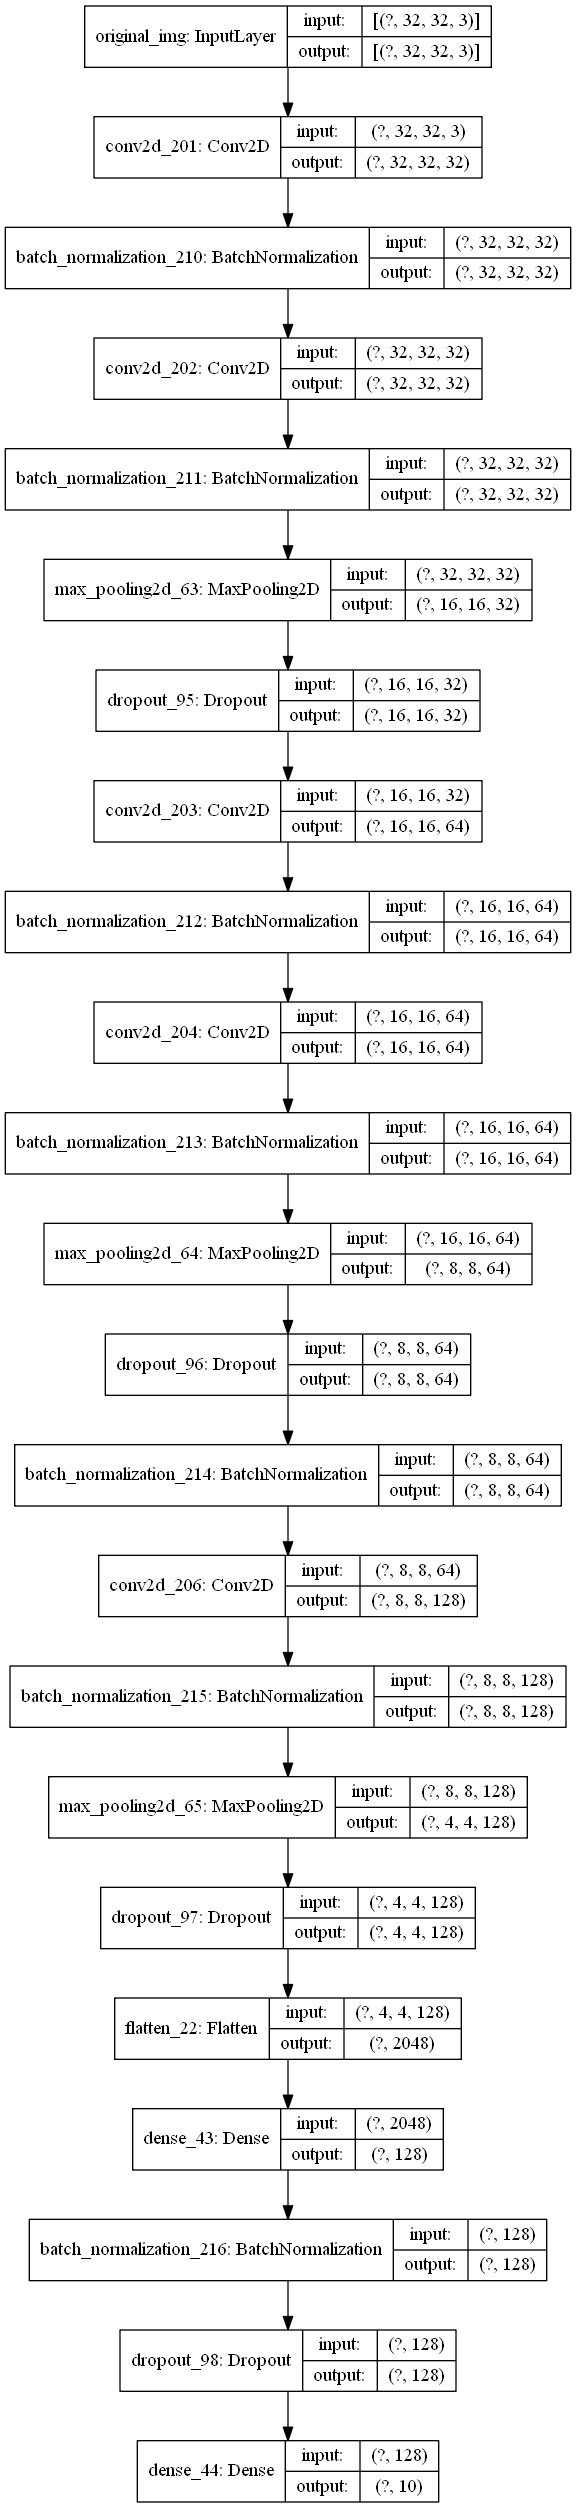

In [238]:
keras.utils.plot_model(model, "cnn.png", show_shapes=True)

In [211]:


batch_size = 50
epochs = 1000
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.001, verbose=1)
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1)

history =model.fit(x_train, y_train,
                epochs=epochs,batch_size = batch_size,callbacks=[reduce_lr, early_stop],
                 verbose=1, validation_data=(X_test, y_test))


Epoch 1/1000
850/850 [==============================] - 10s 12ms/step - loss: 1.9807 - sparse_categorical_accuracy: 0.3446 - val_loss: 1.4911 - val_sparse_categorical_accuracy: 0.4640 - lr: 0.0100
Epoch 2/1000
850/850 [==============================] - 10s 11ms/step - loss: 1.4779 - sparse_categorical_accuracy: 0.4686 - val_loss: 1.4326 - val_sparse_categorical_accuracy: 0.4711 - lr: 0.0100
Epoch 3/1000
850/850 [==============================] - 10s 11ms/step - loss: 1.3567 - sparse_categorical_accuracy: 0.5138 - val_loss: 1.3821 - val_sparse_categorical_accuracy: 0.5029 - lr: 0.0100
Epoch 4/1000
850/850 [==============================] - 10s 11ms/step - loss: 1.2810 - sparse_categorical_accuracy: 0.5403 - val_loss: 1.4845 - val_sparse_categorical_accuracy: 0.4654 - lr: 0.0100
Epoch 5/1000
850/850 [==============================] - 10s 12ms/step - loss: 1.2224 - sparse_categorical_accuracy: 0.5609 - val_loss: 1.3469 - val_sparse_categorical_accuracy: 0.5129 - lr: 0.0100
Epoch 6/1000
85

850/850 [==============================] - 10s 12ms/step - loss: 0.8594 - sparse_categorical_accuracy: 0.7011 - val_loss: 0.9472 - val_sparse_categorical_accuracy: 0.6687 - lr: 0.0010
Epoch 38/1000
850/850 [==============================] - 10s 12ms/step - loss: 0.8504 - sparse_categorical_accuracy: 0.7014 - val_loss: 0.9464 - val_sparse_categorical_accuracy: 0.6637 - lr: 0.0010
Epoch 39/1000
846/850 [============================>.] - ETA: 0s - loss: 0.8543 - sparse_categorical_accuracy: 0.6996
Epoch 00039: ReduceLROnPlateau reducing learning rate to 0.001.
850/850 [==============================] - 10s 12ms/step - loss: 0.8548 - sparse_categorical_accuracy: 0.6994 - val_loss: 0.9411 - val_sparse_categorical_accuracy: 0.6736 - lr: 0.0010
Epoch 40/1000
850/850 [==============================] - 10s 12ms/step - loss: 0.8501 - sparse_categorical_accuracy: 0.7008 - val_loss: 0.9326 - val_sparse_categorical_accuracy: 0.6727 - lr: 0.0010
Epoch 41/1000
850/850 [==============================]

Epoch 72/1000
850/850 [==============================] - 10s 12ms/step - loss: 0.8055 - sparse_categorical_accuracy: 0.7179 - val_loss: 0.8994 - val_sparse_categorical_accuracy: 0.6843 - lr: 0.0010
Epoch 73/1000
846/850 [============================>.] - ETA: 0s - loss: 0.8076 - sparse_categorical_accuracy: 0.7168
Epoch 00073: ReduceLROnPlateau reducing learning rate to 0.001.
850/850 [==============================] - 10s 12ms/step - loss: 0.8081 - sparse_categorical_accuracy: 0.7166 - val_loss: 0.8984 - val_sparse_categorical_accuracy: 0.6888 - lr: 0.0010
Epoch 74/1000
850/850 [==============================] - 10s 12ms/step - loss: 0.8030 - sparse_categorical_accuracy: 0.7183 - val_loss: 0.8790 - val_sparse_categorical_accuracy: 0.6959 - lr: 0.0010
Epoch 75/1000
850/850 [==============================] - 10s 12ms/step - loss: 0.8071 - sparse_categorical_accuracy: 0.7170 - val_loss: 0.8850 - val_sparse_categorical_accuracy: 0.6909 - lr: 0.0010
Epoch 76/1000
850/850 [=================

850/850 [==============================] - 10s 11ms/step - loss: 0.7687 - sparse_categorical_accuracy: 0.7306 - val_loss: 0.8508 - val_sparse_categorical_accuracy: 0.7034 - lr: 0.0010
Epoch 108/1000
850/850 [==============================] - 10s 11ms/step - loss: 0.7629 - sparse_categorical_accuracy: 0.7317 - val_loss: 0.8372 - val_sparse_categorical_accuracy: 0.7080 - lr: 0.0010
Epoch 109/1000
850/850 [==============================] - 10s 12ms/step - loss: 0.7672 - sparse_categorical_accuracy: 0.7323 - val_loss: 0.8310 - val_sparse_categorical_accuracy: 0.7076 - lr: 0.0010
Epoch 110/1000
850/850 [==============================] - 10s 11ms/step - loss: 0.7711 - sparse_categorical_accuracy: 0.7309 - val_loss: 0.8296 - val_sparse_categorical_accuracy: 0.7100 - lr: 0.0010
Epoch 111/1000
850/850 [==============================] - 10s 12ms/step - loss: 0.7650 - sparse_categorical_accuracy: 0.7298 - val_loss: 0.8353 - val_sparse_categorical_accuracy: 0.7115 - lr: 0.0010
Epoch 112/1000
850/8

We will now plot the model accuracy and model loss. In model accuracy we will plot the training accuracy and validation accuracy and in model loss we will plot the training loss and validation loss.

In [212]:
# Plot training & validation accuracy values
def Learning_curve_plot(model,history):
    epoch_range = range(1, len(history.history['sparse_categorical_accuracy'])+1)
    plt.plot(epoch_range, history.history['sparse_categorical_accuracy'])
    plt.plot(epoch_range, history.history['val_sparse_categorical_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(epoch_range, history.history['loss'])
    plt.plot(epoch_range, history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()

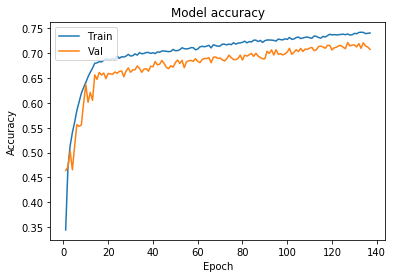

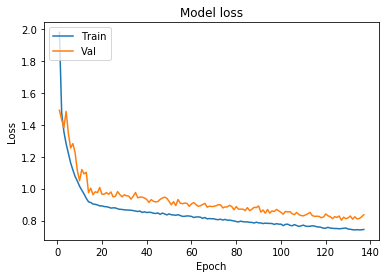

313/313 [==============================] - 1s 4ms/step - loss: 0.8359 - sparse_categorical_accuracy: 0.7074
Test loss: 0.8359068632125854
Test accuracy: 0.7074000239372253


In [213]:
Learning_curve_plot(model,history)
# Score trained model.
scores = model.evaluate(X_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

During the training of a machine-learning model, we want to monitor how well our model is capturing the patterns in the training data. A model that doesn’t capture the patterns very well is said to be underfit; a model that captures the patterns too well, to the extent that what it learns generalizes poorly to new data, is said to be overfit. An overfit model can be brought back on track through countermeasures such as regularization

Reviewing the learning curves, we can see that the model converges well, with performance on the test dataset perhaps following the training graph epochs. Compared to the learning curves for fixed dropout.But still the model is not so much overrfitting.

This is a fruitful area for investigation on this model, and perhaps more dropout layers and/or more aggressive dropout may result in further improvements. Data augmentation can also improve the model performance also.

In [214]:
y_pred =model.predict(X_test)
y_pred[:5]

array([[3.4070382e-04, 6.2270730e-05, 1.9674911e-03, 7.4337089e-01,
        1.3327040e-03, 1.7873460e-01, 6.8089031e-02, 6.9471070e-04,
        5.2281450e-03, 1.7954310e-04],
       [2.8680166e-04, 1.9658043e-03, 1.5754435e-06, 4.1093099e-06,
        6.5320341e-07, 7.5896843e-08, 7.5781991e-06, 5.3629655e-08,
        9.9766773e-01, 6.5595021e-05],
       [7.8760255e-03, 4.9083051e-03, 2.0416244e-04, 6.2797964e-04,
        2.1043263e-04, 2.6839116e-05, 3.2750005e-04, 2.0798665e-05,
        9.8513675e-01, 6.6120783e-04],
       [1.4922448e-01, 4.6874122e-03, 1.0236736e-02, 1.8662957e-03,
        3.5505721e-03, 3.0874740e-05, 5.6367326e-03, 6.0160135e-05,
        8.2442975e-01, 2.7702152e-04],
       [1.4666625e-06, 4.2747056e-06, 2.0750889e-03, 5.1466976e-03,
        4.5281653e-03, 1.0930736e-04, 9.8810238e-01, 9.6585916e-07,
        3.0853560e-05, 8.0500240e-07]], dtype=float32)

In [215]:
y_pred = [np.argmax(element) for element in y_pred]
y_pred[:5]

[3, 8, 8, 8, 6]

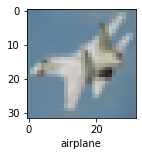

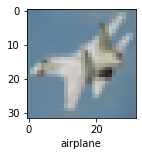

In [216]:
plot_sample(X_test, y_test,10)
plot_sample(X_test, y_pred,10)

(<Figure size 648x648 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x20611d7ba08>)

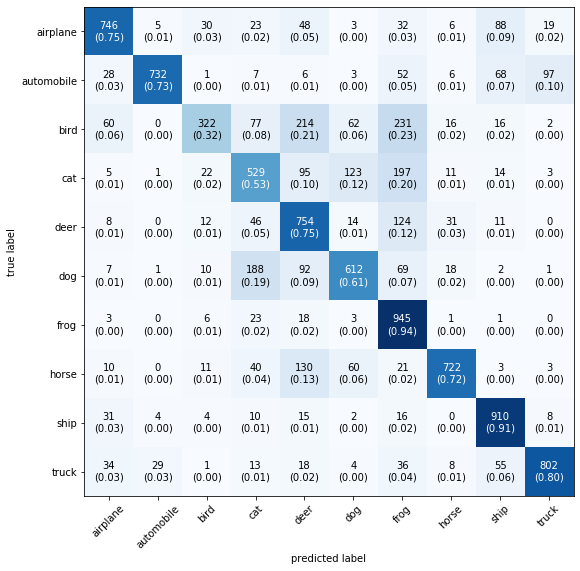

In [217]:
mat = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(mat,figsize=(9,9), class_names=classes, show_normed=True)

In [218]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.80      0.75      0.77      1000
           1       0.95      0.73      0.83      1000
           2       0.77      0.32      0.45      1000
           3       0.55      0.53      0.54      1000
           4       0.54      0.75      0.63      1000
           5       0.69      0.61      0.65      1000
           6       0.55      0.94      0.69      1000
           7       0.88      0.72      0.79      1000
           8       0.78      0.91      0.84      1000
           9       0.86      0.80      0.83      1000

    accuracy                           0.71     10000
   macro avg       0.74      0.71      0.70     10000
weighted avg       0.74      0.71      0.70     10000



The overall accuracy of the classifier model without augmentation is 71%.

In [219]:
save_dir = 'saved_models'
model_name = 'keras_cifar10_trained_model.h5'
# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

Saved trained model at saved_models\keras_cifar10_trained_model.h5 


Now let's build the decoder model.

In [196]:
decoder_input = keras.Input(shape=(8,8,64,), name="encoded_img")
cn7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(decoder_input)
cn8 =BatchNormalization()(cn7)
cn9 =Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(cn8)
cn10 = BatchNormalization()(cn9)
cn11 =UpSampling2D((2, 2))(cn10)
cn12 =Dropout(0.3)(cn11)
cn13 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(cn12)
cn14 =BatchNormalization()(cn13)
cn15 =Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(cn14)
cn16 = BatchNormalization()(cn15)
cn17 =UpSampling2D((2, 2))(cn16)
decoder_output =Conv2D(x_train.shape[-1],(3, 3),activation='sigmoid', kernel_initializer='he_uniform', padding='same')(cn17)
decoder = keras.Model(decoder_input, decoder_output, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoded_img (InputLayer)     [(None, 8, 8, 64)]        0         
_________________________________________________________________
conv2d_194 (Conv2D)          (None, 8, 8, 64)          36928     
_________________________________________________________________
batch_normalization_203 (Bat (None, 8, 8, 64)          256       
_________________________________________________________________
conv2d_195 (Conv2D)          (None, 8, 8, 64)          36928     
_________________________________________________________________
batch_normalization_204 (Bat (None, 8, 8, 64)          256       
_________________________________________________________________
up_sampling2d_26 (UpSampling (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_91 (Dropout)         (None, 16, 16, 64)        0   

Plot the decoder model

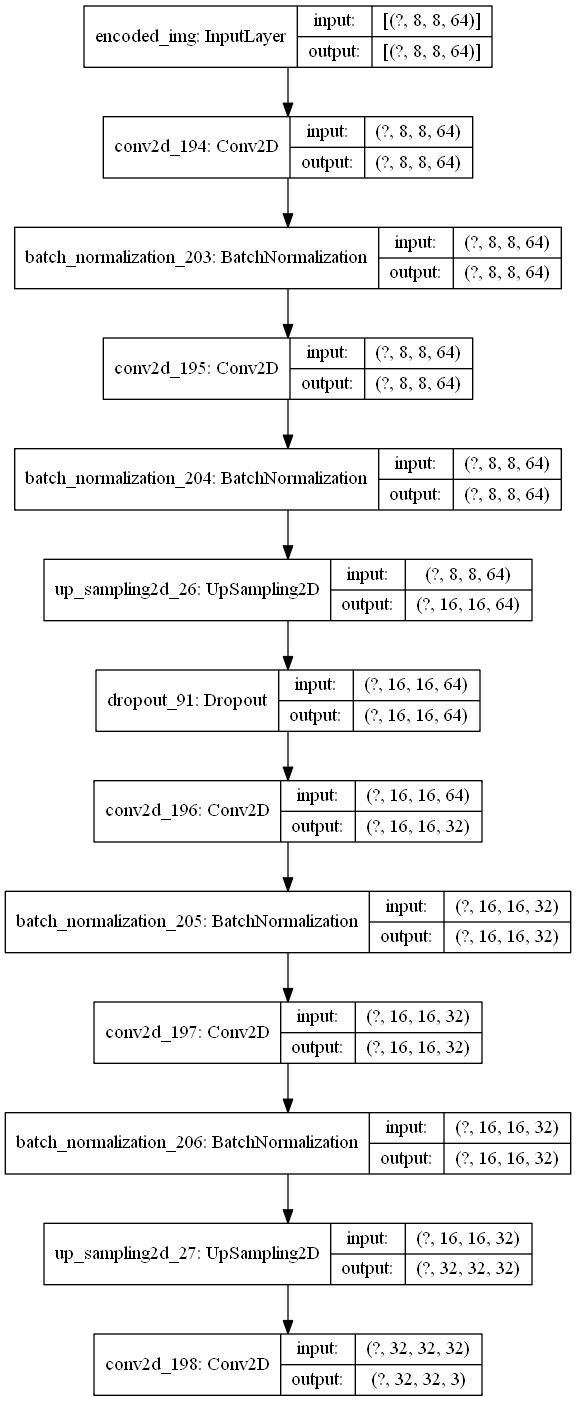

In [240]:
keras.utils.plot_model(decoder, "decoder.png", show_shapes=True)

In [186]:
CAE_input = keras.Input(shape=x_train.shape[1:], name="img")
encoded_img = encoder(CAE_input)
decoded_img = decoder(encoded_img)
autoencoder = keras.Model(CAE_input, decoded_img, name="CAE")
autoencoder.summary()
opt = SGD(lr=0.05)
autoencoder.compile(optimizer=opt, loss='binary_crossentropy',metrics=['accuracy'])

Model: "CAE"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img (InputLayer)             [(None, 32, 32, 3)]       0         
_________________________________________________________________
encoder (Model)              (None, 8, 8, 64)          66336     
_________________________________________________________________
decoder (Model)              (None, 32, 32, 3)         103203    
Total params: 169,539
Trainable params: 168,771
Non-trainable params: 768
_________________________________________________________________


In [187]:
batch_size = 50
epochs = 1000
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.001, verbose=1)
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1)

# callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
history =autoencoder.fit(x_train, x_train,
                epochs=epochs,callbacks=[reduce_lr,early_stop],
                 verbose=1,
                batch_size=batch_size, validation_data=(X_test, X_test))

Epoch 1/1000
850/850 [==============================] - 14s 16ms/step - loss: 0.6176 - accuracy: 0.4705 - val_loss: 0.5896 - val_accuracy: 0.5549 - lr: 0.0500
Epoch 2/1000
850/850 [==============================] - 14s 16ms/step - loss: 0.5880 - accuracy: 0.5535 - val_loss: 0.5828 - val_accuracy: 0.5838 - lr: 0.0500
Epoch 3/1000
850/850 [==============================] - 14s 16ms/step - loss: 0.5827 - accuracy: 0.5803 - val_loss: 0.5796 - val_accuracy: 0.6012 - lr: 0.0500
Epoch 4/1000
850/850 [==============================] - 14s 16ms/step - loss: 0.5797 - accuracy: 0.5945 - val_loss: 0.5774 - val_accuracy: 0.6086 - lr: 0.0500
Epoch 5/1000
850/850 [==============================] - 14s 16ms/step - loss: 0.5778 - accuracy: 0.6034 - val_loss: 0.5760 - val_accuracy: 0.6168 - lr: 0.0500
Epoch 6/1000
850/850 [==============================] - 14s 16ms/step - loss: 0.5763 - accuracy: 0.6096 - val_loss: 0.5751 - val_accuracy: 0.6235 - lr: 0.0500
Epoch 7/1000
850/850 [========================

850/850 [==============================] - 14s 16ms/step - loss: 0.5642 - accuracy: 0.7170 - val_loss: 0.5637 - val_accuracy: 0.7295 - lr: 0.0500
Epoch 53/1000
849/850 [============================>.] - ETA: 0s - loss: 0.5641 - accuracy: 0.7173
Epoch 00053: ReduceLROnPlateau reducing learning rate to 0.010000000149011612.
850/850 [==============================] - 14s 16ms/step - loss: 0.5641 - accuracy: 0.7174 - val_loss: 0.5636 - val_accuracy: 0.7309 - lr: 0.0500
Epoch 54/1000
850/850 [==============================] - 14s 16ms/step - loss: 0.5641 - accuracy: 0.7172 - val_loss: 0.5635 - val_accuracy: 0.7322 - lr: 0.0100
Epoch 55/1000
850/850 [==============================] - 14s 16ms/step - loss: 0.5639 - accuracy: 0.7184 - val_loss: 0.5635 - val_accuracy: 0.7334 - lr: 0.0100
Epoch 56/1000
850/850 [==============================] - 14s 16ms/step - loss: 0.5640 - accuracy: 0.7186 - val_loss: 0.5635 - val_accuracy: 0.7321 - lr: 0.0100
Epoch 57/1000
849/850 [===========================

In [188]:
# Plot training & validation accuracy,loss values for autoencoder
def Autoencoder_Learning_curve_plot(autoencoder,history):
    epoch_range = range(1, len(history.history['accuracy'])+1)
    plt.plot(epoch_range, history.history['accuracy'])
    plt.plot(epoch_range, history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(epoch_range, history.history['loss'])
    plt.plot(epoch_range, history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()

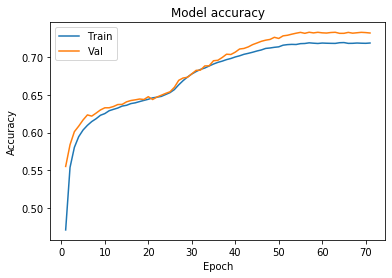

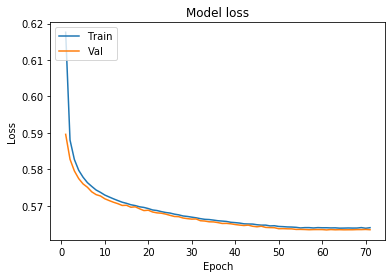

In [189]:
Autoencoder_Learning_curve_plot(autoencoder,history)

From the above graph of autoencoder we see that the curve is well fitting and it is between overfitting and underfitting.

# Reconstruction of images 

In [190]:
decoded_imgs = autoencoder.predict(X_test)

In [191]:
decoded_imgs.shape

(10000, 32, 32, 3)

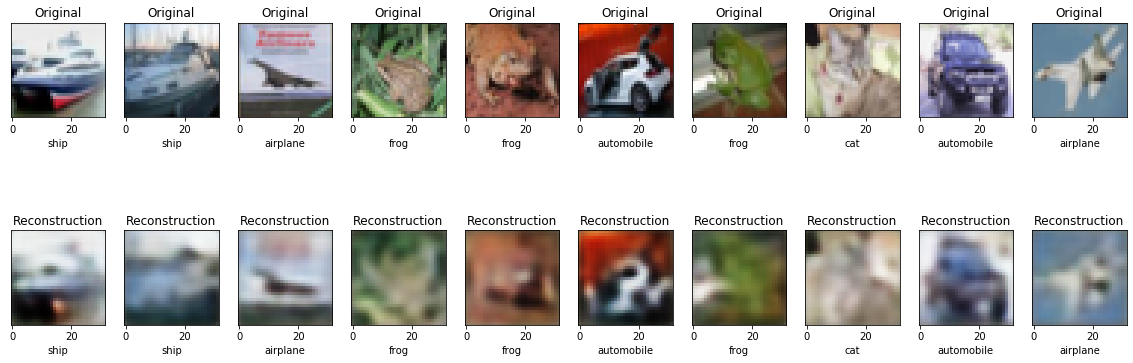

In [192]:
import matplotlib.pyplot as plt
n = 10
plt.figure(figsize=(20, 7))
for i in range(1, n + 1):
    # Display original
    ax = plt.subplot(2, n, i)
    plt.imshow(X_test[i])
    plt.xlabel(classes[y_test[i]])
#     ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.title('Original',fontsize = 12)

    # Display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i])
    plt.xlabel(classes[y_test[i]])
#     ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.title('Reconstruction',fontsize = 12)
plt.show()

## Dropout and Data Augmentation and Batch Normalization for classification

We can expand upon the previous example in a few ways.

First, we can increase the number of training epochs from 200 to 1000, to give the model more of an opportunity to improve.

Next, we can add batch normalization in an effort to stabilize the learning and perhaps accelerate the learning process. To offset this acceleration, we can increase the regularization by changing the dropout from a fixed pattern to an increasing pattern. Data augmentation improve the model. So, lets apply the augmentation.

In [221]:
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


In [225]:

# create data generator

datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)

# prepare iterator

it_train = datagen.flow(x_train, y_train, batch_size=64)

# fit model

steps = int(x_train.shape[0] / 64)

history = model.fit_generator(it_train, steps_per_epoch=steps, epochs=1000,callbacks=[reduce_lr,early_stop],
                              validation_data=(X_test, y_test), verbose=1)

# evaluate model

_, acc = model.evaluate(X_test, y_test, verbose=0)

Epoch 1/200
664/664 [==============================] - 12s 19ms/step - loss: 0.7347 - sparse_categorical_accuracy: 0.7458 - val_loss: 0.7036 - val_sparse_categorical_accuracy: 0.7553 - lr: 0.0010
Epoch 2/200
664/664 [==============================] - 12s 19ms/step - loss: 0.7299 - sparse_categorical_accuracy: 0.7455 - val_loss: 0.7101 - val_sparse_categorical_accuracy: 0.7544 - lr: 0.0010
Epoch 3/200
664/664 [==============================] - 13s 19ms/step - loss: 0.7337 - sparse_categorical_accuracy: 0.7446 - val_loss: 0.7124 - val_sparse_categorical_accuracy: 0.7545 - lr: 0.0010
Epoch 4/200
664/664 [==============================] - ETA: 0s - loss: 0.7365 - sparse_categorical_accuracy: 0.7423
Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.001.
664/664 [==============================] - 13s 20ms/step - loss: 0.7365 - sparse_categorical_accuracy: 0.7423 - val_loss: 0.7223 - val_sparse_categorical_accuracy: 0.7501 - lr: 0.0010
Epoch 5/200
664/664 [===========================

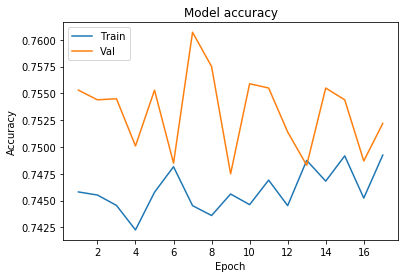

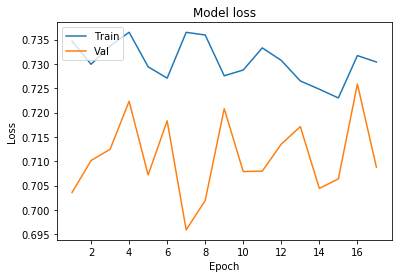

In [227]:
Learning_curve_plot(model,history)

The model is now learning well and we have good control over the rate of learning without overfitting.

We might be able to achieve further improvements with additional regularization. This could be achieved with more aggressive dropout in later layers. 

In [228]:

scores = model.evaluate(X_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

313/313 [==============================] - 1s 4ms/step - loss: 0.7088 - sparse_categorical_accuracy: 0.7522
Test loss: 0.7087596654891968
Test accuracy: 0.7522000074386597


In [229]:
y_pred =model.predict(X_test)
y_pred = [np.argmax(element) for element in y_pred]
mat = confusion_matrix(y_test, y_pred)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.81      0.79      0.80      1000
           1       0.96      0.82      0.88      1000
           2       0.84      0.36      0.50      1000
           3       0.59      0.58      0.58      1000
           4       0.64      0.76      0.69      1000
           5       0.68      0.71      0.69      1000
           6       0.61      0.94      0.74      1000
           7       0.87      0.78      0.83      1000
           8       0.84      0.92      0.88      1000
           9       0.88      0.85      0.87      1000

    accuracy                           0.75     10000
   macro avg       0.77      0.75      0.75     10000
weighted avg       0.77      0.75      0.75     10000



We can see here that with augmentation the model accuracy is increased.

(<Figure size 648x648 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x2061222bcc8>)

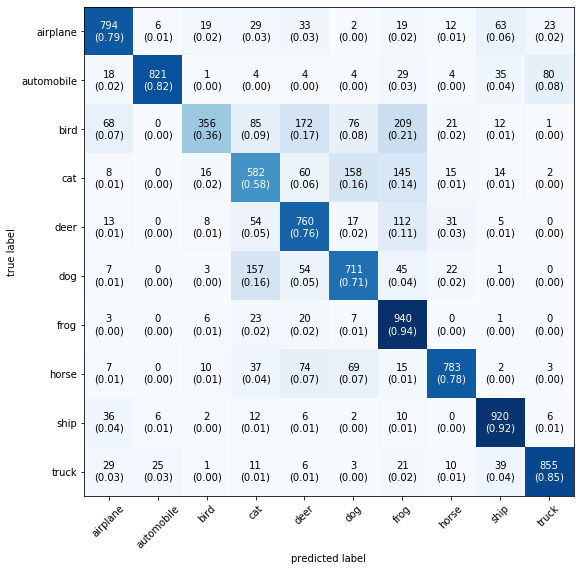

In [230]:
plot_confusion_matrix(mat,figsize=(9,9), class_names=classes, show_normed=True)

Let's save the model.

In [241]:
save_dir = 'saved_models'
model_name = 'keras_cifar10_trained_model_augmentation.h5'
# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

Saved trained model at saved_models\keras_cifar10_trained_model_augmentation.h5 


## Discussion

In this section, I explored two approaches designed to expand upon changes to the model that we know already result in an improvement. Though I experiment different model which is given below but i just mension here the result.

A summary of the results is provided below:

Baseline +  Dropout: 65.690%
Baseline + Dropout + Batch Normalization: 71.00%
Baseline + Dropout + Data Augmentation + Batch Normalization: 75.620%